In [1]:
# Import the required packages and functions
import matplotlib.pyplot as plt
import numpy as np
import time

from ml_control.greedy_algorithm import greedy
from ml_control.problem_definitions.heat_equation import create_heat_equation_problem_complex
from ml_control.reduced_model import ReducedModel
from ml_control.machine_learning_models.kernel_reduced_model import KernelReducedModel
from ml_control.systems import solve_optimal_control_problem, get_control_from_final_time_adjoint
from ml_control.visualization import plot_final_time_adjoints, plot_controls

In [2]:
# Define the system components
system_dimension = 50
T, nt, N, h, parametrized_A, parametrized_B, parametrized_x0, parametrized_xT, R_chol, M, parameter_space = create_heat_equation_problem_complex(system_dimension)
spatial_norm = lambda x: np.linalg.norm(h * x)
temporal_norm = lambda u: np.linalg.norm(u * (T / nt))

In [3]:
# Run the greedy algorithm
k_train = 8
training_parameters = np.array(np.meshgrid(np.linspace(*parameter_space[0], k_train),
                                           np.linspace(*parameter_space[1], k_train))).T.reshape(-1, 2)
tol = 1e-6
max_basis_size = k_train ** 2

_, reduced_basis, _, estimated_errors, training_data = greedy(training_parameters, N, T, nt, parametrized_A, parametrized_B, parametrized_x0, parametrized_xT, R_chol, M,
                                                              tol=tol, max_basis_size=max_basis_size, return_errors_and_efficiencies=False, spatial_norm=spatial_norm)

00:01 greedy: Select first parameter ...
00:15 greedy: Determined first parameter with error 0.10892112514412104 ...
00:15 greedy: Starting greedy parameter selection ...
00:15 greedy: Determined next parameter number 63 with error 0.10892112514412104 ...
00:15 greedy: Parameter selection step 1:
00:15 |   greedy: Computing optimal adjoint for selected parameter mu=[2.  1.5] ...
00:20 |   greedy: Checking errors on training set ...
00:34 |   greedy: Maximum estimated error on training set: 0.02082168738943819
      \----------------- duration: 18.431391160935163s
00:34 greedy: Determined next parameter number 0 with error 0.02082168738943819 ...
00:34 greedy: Parameter selection step 2:
00:34 |   greedy: Computing optimal adjoint for selected parameter mu=[1.  0.5] ...
00:38 |   greedy: Checking errors on training set ...
01:02 |   greedy: Maximum estimated error on training set: 0.00410206535514565
      \----------------- duration: 28.382851883769035s
01:02 greedy: Determined next pa

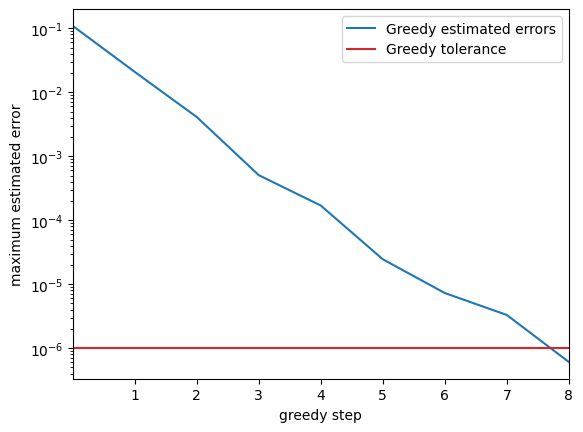

In [4]:
# Plot the greedy errors
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(np.arange(0, len(estimated_errors)), estimated_errors, 'tab:blue', label='Greedy estimated errors')
ax.plot(np.arange(0, len(estimated_errors)), [tol] * len(estimated_errors), 'tab:red', label='Greedy tolerance')
ax.set_xlim((0., len(reduced_basis)))
ax.set_xlabel('greedy step')
ax.set_ylabel('maximum estimated error')
ax.set_xticks(np.arange(0, len(reduced_basis)) + 1)
ax.legend()
plt.show()

In [5]:
# Instantiate the reduced model
rb_rom = ReducedModel(reduced_basis, N, T, nt, parametrized_A, parametrized_B, parametrized_x0, parametrized_xT, R_chol,
                      M, spatial_norm=spatial_norm)

In [6]:
# Instantiate and train the machine learning model
ml_rom = KernelReducedModel(rb_rom, training_data, T, nt, parametrized_A, parametrized_B, parametrized_x0,
                            parametrized_xT, R_chol, M, spatial_norm=spatial_norm)
ml_rom.train()


****************************** [VKOGA] ******************************
Training model with
       |_ kernel              : gauss [gamma = 1.00e+00]
       |_ regularization par. : 0.00e+00
       |_ restriction par.    : 0.00e+00

Training ongoing with
       |_ selected points     :        1 /       56
       |_ train residual      : 2.03e-01 / 1.00e-10
       |_ train power fun     : 1.00e+00 / 1.00e-10
Training ongoing with
       |_ selected points     :       11 /       56
       |_ train residual      : 5.20e-04 / 1.00e-10
       |_ train power fun     : 3.73e-03 / 1.00e-10
Training ongoing with
       |_ selected points     :       21 /       56
       |_ train residual      : 4.60e-06 / 1.00e-10
       |_ train power fun     : 1.31e-05 / 1.00e-10
Training ongoing with
       |_ selected points     :       31 /       56
       |_ train residual      : 3.40e-08 / 1.00e-10
       |_ train power fun     : 9.71e-08 / 1.00e-10
Training ongoing with
       |_ selected points     :    

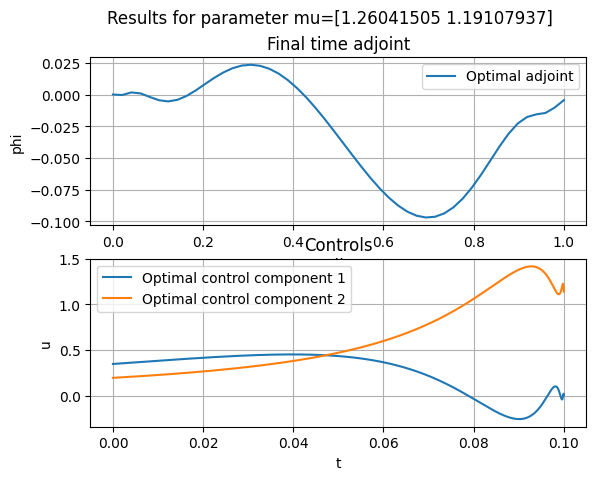

In [10]:
# Run the full model for a test parameter
mu = np.stack([np.random.uniform(np.array(parameter_space)[0,0], np.array(parameter_space)[0,1], 1),
               np.random.uniform(np.array(parameter_space)[1,0], np.array(parameter_space)[1,1], 1)]).T[0]

x0 = parametrized_x0(mu)
xT = parametrized_xT(mu)
A = parametrized_A(mu)
B = parametrized_B(mu)
phiT_init = np.zeros(N)
tic = time.perf_counter()
phi_opt = solve_optimal_control_problem(x0, xT, T, nt, A, B, R_chol, M, phiT_init)
u_opt = get_control_from_final_time_adjoint(phi_opt, T, nt, A, B, R_chol)
time_full = time.perf_counter() - tic

fig, axs = plt.subplots(2)
plot_final_time_adjoints([phi_opt], labels=["Optimal adjoint"], show_plot=False, ax=axs[0])
axs[0].set_title("Final time adjoint")
axs[0].legend()
plot_controls([u_opt], T, labels=["Optimal control"], show_plot=False, ax=axs[1])
axs[1].set_title("Controls")
axs[1].legend()
fig.suptitle(f"Results for parameter mu={mu}")
plt.show()

In [11]:
# Run the two reduced models for the test parameter
tic = time.perf_counter()
u_rb, phi_rb = rb_rom.solve(mu)
time_rb = time.perf_counter() - tic

tic = time.perf_counter()
u_ml, phi_ml = ml_rom.solve(mu)
time_ml = time.perf_counter() - tic

In [12]:
print("Full model:")
print("===========")
print(f"Runtime: {time_full}")

print()
print("Reduced model:")
print("==============")
print(f"Reduced basis size: {len(rb_rom.reduced_basis)}")
print(f"Runtime: {time_rb}")
print(f"Speedup: {time_full / time_rb}")
print(f"Relative error in final time adjoint: {spatial_norm(phi_opt - phi_rb) / spatial_norm(phi_opt)}")
print(f"Error in control: {temporal_norm(u_opt - u_rb)}")

print()
print("ML reduced model:")
print("=================")
print(f"Runtime: {time_ml}")
print(f"Speedup: {time_full / time_ml}")
print(f"Relative error in final time adjoint: {spatial_norm(phi_opt - phi_ml) / spatial_norm(phi_opt)}")
print(f"Error in control: {temporal_norm(u_opt - u_ml)}")

Full model:
Runtime: 4.675557643175125

Reduced model:
Reduced basis size: 8
Runtime: 1.5799843068234622
Speedup: 2.9592430905692173
Relative error in final time adjoint: 1.0770922991866038e-05
Error in control: 6.4317262388494e-09

ML reduced model:
Runtime: 0.10417100181803107
Speedup: 44.88348543813109
Relative error in final time adjoint: 1.1040354799032438e-05
Error in control: 7.962973727827527e-09
